In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import tetrion.db as db
# DB connection: assume you already have `conn`
# from tetrion import db
# conn = db.get_conn("timescale_production_capital")

# Date range for the query
d1 = dt.datetime(2025, 6, 1, 0, 0)
d2 = dt.datetime(2025, 11, 1, 23, 59)
conn = db.get_conn("timescale_research_rk")
# VIX config
min_T_days = 5.0    # ignore maturities < 5 days
max_T_days = 90.0   # ignore maturities > 90 days
target_days = 30.0  # 30-day VIX-like horizon


In [2]:
conn = db.get_conn("timescale_research_rk")


In [9]:
# Cell 2 – Corrected version (only 08:45–13:45, 5-minute buckets, maturity filter)

stmt = """
WITH snap AS (
    SELECT
        date_trunc('minute', time) AS t_min,   -- << 用這個去 group 5 分鐘
        sym,
        exp,
        "right",
        strike,
        instr,
        value,
        forward,
        maturity,
        discount
    FROM optionvalues_1min
    WHERE time >= %(d1)s
      AND time <= %(d2)s
      AND lower(sym) LIKE 'opt_taifex_txo%%'
      AND value IS NOT NULL
      AND forward IS NOT NULL
      AND maturity BETWEEN %(min_T)s AND %(max_T)s
)
SELECT
    t_min AS time,          -- << 外層只能用 t_min
    sym,
    exp,
    "right",
    strike,
    instr,
    value,
    forward,
    maturity,
    discount
FROM snap
WHERE
    (
        (EXTRACT(HOUR FROM t_min) = 8 AND EXTRACT(MINUTE FROM t_min) >= 45)
        OR (EXTRACT(HOUR FROM t_min) BETWEEN 9 AND 12)
        OR (EXTRACT(HOUR FROM t_min) = 13 AND EXTRACT(MINUTE FROM t_min) <= 45)
    )
    AND (EXTRACT(MINUTE FROM t_min)::int %% 5) = 0   -- 5-minute grid
ORDER BY time, exp, strike;
"""

params = {
    "d1": d1,
    "d2": d2,
    "min_T": min_T_days / 365.0,
    "max_T": max_T_days / 365.0,
}

df_raw = pd.read_sql(stmt, con=conn, params=params)
df_raw["time"] = pd.to_datetime(df_raw["time"])




In [10]:
def compute_expiry_variance(df_expiry, target_forward_col="forward"):
    """
    Compute model-free implied variance for a single expiry,
    using a VIX-style formula.

    df_expiry: DataFrame for a single expiry (same maturity)
               must have columns:
               - right: 'C' or 'P'
               - strike
               - value
               - maturity
               optionally:
               - discount
               - forward
    """
    df_e = df_expiry.copy()

    # Basic cleaning
    df_e = df_e.dropna(subset=["right", "strike", "value", "maturity"])
    if df_e.empty:
        return np.nan, np.nan

    # Maturity and discount (should be identical within this expiry)
    T = float(df_e["maturity"].iloc[0])
    if T <= 0:
        return np.nan, T

    if "discount" in df_e.columns and pd.notna(df_e["discount"].iloc[0]):
        disc = float(df_e["discount"].iloc[0])
        if disc > 0 and disc not in (0.0, 1.0):
            r = -np.log(disc) / T
        else:
            r = 0.0
    else:
        r = 0.0

    # Forward: use column if it's positive, otherwise estimate via put-call parity
    F = None
    if target_forward_col in df_e.columns and df_e[target_forward_col].notna().any():
        F_candidate = float(df_e[target_forward_col].dropna().iloc[0])
        if F_candidate > 0:
            F = F_candidate

    if F is None:
        tbl_fp = df_e.pivot_table(
            index="strike",
            columns="right",
            values="value",
            aggfunc="mean"
        )
        tbl_fp = tbl_fp.dropna(subset=["C", "P"], how="any")
        if tbl_fp.empty:
            return np.nan, T

        diff = (tbl_fp["C"] - tbl_fp["P"]).abs()
        K0_est = diff.idxmin()
        C0 = tbl_fp.loc[K0_est, "C"]
        P0 = tbl_fp.loc[K0_est, "P"]
        F = K0_est + np.exp(r * T) * (C0 - P0)

    # Build call/put table for full integration
    tbl = df_e.pivot_table(
        index="strike",
        columns="right",
        values="value",
        aggfunc="mean"
    )

    strikes = np.array(sorted(tbl.index.values))
    if len(strikes) < 2:
        return np.nan, T

    # Find K0: largest strike <= F
    strikes_le_F = strikes[strikes <= F]
    if len(strikes_le_F) == 0:
        K0 = strikes[0]
    else:
        K0 = strikes_le_F.max()

    # Construct Q(K): OTM option price
    Q = []
    for K in strikes:
        row = tbl.loc[K]
        Ck = row["C"] if "C" in row and not np.isnan(row["C"]) else np.nan
        Pk = row["P"] if "P" in row and not np.isnan(row["P"]) else np.nan

        if K < K0:
            qk = Pk  # OTM put
        elif K > K0:
            qk = Ck  # OTM call
        else:
            # ATM: average of call and put
            if np.isnan(Ck) or np.isnan(Pk):
                qk = np.nanmean([Ck, Pk])
            else:
                qk = 0.5 * (Ck + Pk)
        Q.append(qk)

    Q = np.array(Q, dtype=float)

    # Remove NaN prices
    mask = ~np.isnan(Q)
    strikes = strikes[mask]
    Q = Q[mask]

    if len(strikes) < 2:
        return np.nan, T

    # Delta K
    dK = np.zeros_like(strikes)
    dK[1:-1] = (strikes[2:] - strikes[:-2]) / 2.0
    dK[0] = strikes[1] - strikes[0]
    dK[-1] = strikes[-1] - strikes[-2]

    # Re-find K0 after filtering
    strikes_le_F = strikes[strikes <= F]
    if len(strikes_le_F) == 0:
        K0_eff = strikes[0]
    else:
        K0_eff = strikes_le_F.max()

    # VIX-style variance formula
    term1 = (2.0 / T) * np.sum(dK / (strikes ** 2) * np.exp(r * T) * Q)
    term2 = (1.0 / T) * ((F / K0_eff - 1.0) ** 2)
    var = term1 - term2

    var = max(var, 0.0)
    return var, T


In [11]:
def compute_vix_like(
    df_snapshot,
    target_days=30.0,
    forward_col="forward",
    min_T_days=5.0,
    max_T_days=90.0
):
    # Keep only necessary columns
    required_cols = ["exp", "right", "strike", "value", "maturity", forward_col, "discount"]
    cols_present = [c for c in required_cols if c in df_snapshot.columns]
    df = df_snapshot[cols_present].copy()

    # maturity filter
    if "maturity" in df.columns:
        df = df[(df["maturity"] >= min_T_days / 365.0) &
                (df["maturity"] <= max_T_days / 365.0)]

    if df.empty:
        return np.nan, None

    results = []
    for exp, df_expiry in df.groupby("exp"):
        var, T = compute_expiry_variance(df_expiry, target_forward_col=forward_col)
        if not np.isnan(var) and T > 0:
            results.append({"exp": exp, "T": T, "variance": var})

    if not results:
        return np.nan, None

    res_df = pd.DataFrame(results)
    # Ensure only the expected columns exist here
    res_df = res_df[["exp", "T", "variance"]].sort_values("T").reset_index(drop=True)

    target_T = target_days / 365.0

    # Only one expiry: simple rescaling to target_T
    if len(res_df) == 1:
        var = float(res_df["variance"].iloc[0])
        T = float(res_df["T"].iloc[0])
        if T <= 0:
            return np.nan, res_df
        var_target = var * target_T / T
    else:
        before = res_df[res_df["T"] <= target_T]
        after = res_df[res_df["T"] >= target_T]

        if not before.empty and not after.empty:
            # nearest below and above
            T1 = float(before["T"].iloc[-1])
            var1 = float(before["variance"].iloc[-1])
            T2 = float(after["T"].iloc[0])
            var2 = float(after["variance"].iloc[0])
        elif before.empty:
            # all maturities > target_T: use two smallest T
            tmp = res_df.nsmallest(2, "T")
            T1 = float(tmp["T"].iloc[0])
            var1 = float(tmp["variance"].iloc[0])
            T2 = float(tmp["T"].iloc[1])
            var2 = float(tmp["variance"].iloc[1])
        else:
            # all maturities < target_T: use two largest T
            tmp = res_df.nlargest(2, "T")
            T1 = float(tmp["T"].iloc[0])
            var1 = float(tmp["variance"].iloc[0])
            T2 = float(tmp["T"].iloc[1])
            var2 = float(tmp["variance"].iloc[1])

        if T1 == T2:
            var_target = var1
        else:
            w1 = (T2 - target_T) / (T2 - T1)
            w2 = (target_T - T1) / (T2 - T1)
            var_target = w1 * var1 + w2 * var2

    vix_like = 100.0 * np.sqrt(max(var_target, 0.0))
    return vix_like, res_df


In [12]:
def compute_vix_time_series(
    df_all,
    target_days=30.0,
    forward_col="forward",
    min_T_days=5.0,
    max_T_days=90.0
):
    df_all = df_all.copy()

    if not np.issubdtype(df_all["time"].dtype, np.datetime64):
        df_all["time"] = pd.to_datetime(df_all["time"])

    records = []

    # Each distinct time is one snapshot surface
    for t, df_snap in df_all.groupby("time"):
        vix_val, _ = compute_vix_like(
            df_snap,
            target_days=target_days,
            forward_col=forward_col,
            min_T_days=min_T_days,
            max_T_days=max_T_days,
        )
        records.append({"time": t, "vix_like": vix_val})

    vix_df = pd.DataFrame(records).sort_values("time").reset_index(drop=True)
    return vix_df


vix_ts = compute_vix_time_series(
    df_raw,
    target_days=target_days,
    forward_col="forward",
    min_T_days=min_T_days,
    max_T_days=max_T_days,
)

print(vix_ts.shape)
vix_ts.head()


(5659, 2)


,time,vix_like
0,2025-06-02 08:45:00,28.349213
1,2025-06-02 08:50:00,26.695815
2,2025-06-02 08:55:00,26.974711
3,2025-06-02 09:00:00,26.569628
4,2025-06-02 09:05:00,26.581695


In [13]:
vix_ts

,time,vix_like
0,2025-06-02 08:45:00,28.349213
1,2025-06-02 08:50:00,26.695815
2,2025-06-02 08:55:00,26.974711
3,2025-06-02 09:00:00,26.569628
4,2025-06-02 09:05:00,26.581695
...,...,...
5654,2025-10-16 13:25:00,27.072439
5655,2025-10-16 13:30:00,26.912163
5656,2025-10-16 13:35:00,26.633825
5657,2025-10-16 13:40:00,26.338607


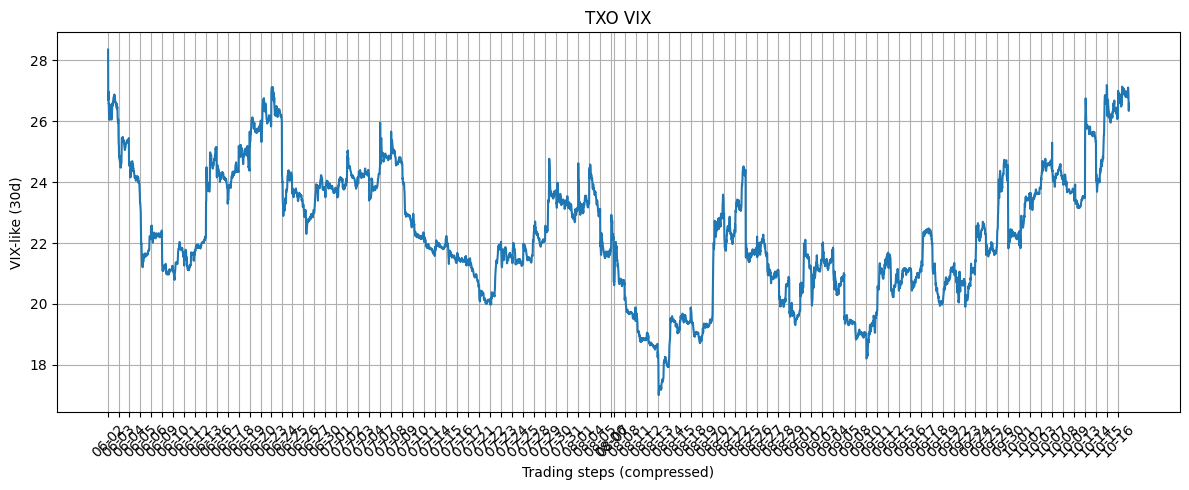

In [14]:
vix_plot = vix_ts.sort_values("time").reset_index(drop=True)

plt.figure(figsize=(12, 5))
plt.plot(vix_plot.index, vix_plot["vix_like"])

# 換成比較好看的 x tick：只標每天第一筆的 index + 日期
day_change = vix_plot["time"].dt.normalize().diff().dt.days.fillna(0)
day_start_idx = vix_plot.index[day_change != 0].tolist()
# 把第一個點也補上
if 0 not in day_start_idx:
    day_start_idx = [0] + day_start_idx

plt.xticks(
    day_start_idx,
    [vix_plot.loc[i, "time"].strftime("%m-%d") for i in day_start_idx],
    rotation=45
)

plt.xlabel("Trading steps (compressed)")
plt.ylabel(f"VIX-like ({int(target_days)}d)")
plt.title("TXO VIX")
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
vix_ts.to_pickle("txo_vix_2025H2.pkl")

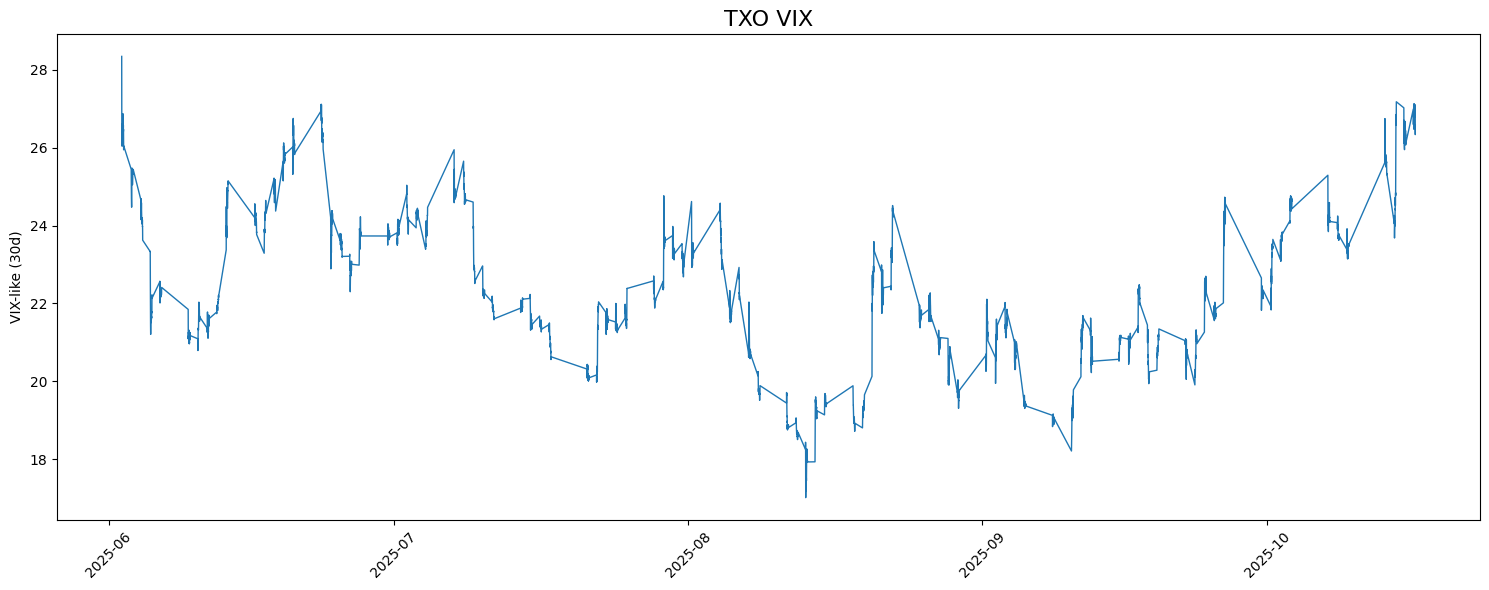

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(vix_ts["time"], vix_ts["vix_like"], lw=1)

ax.set_title("TXO VIX", fontsize=16)
ax.set_ylabel("VIX-like (30d)")

# --- 日期格式化：只顯示月份 ---
import matplotlib.dates as mdates

# 每個月一個 major tick
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# 若你 intraday 很密，建議把 minor tick 拿掉

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
